In [16]:
import tensorflow as tf
import keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.models import Sequential
from keras.models import model_from_json 
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import np_utils
import glob        
import sys
import numpy as np
import matplotlib.pyplot as plt 
import PIL
from PIL import Image
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore") 
import mymodule
from mymodule import BatchGenerator
from mymodule import Make_Raw_List2
from mymodule import plot_loss_accuracy_graph

In [2]:
import pandas as pd
import numpy as np
import shutil
import os
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
#label the normal and abnormal fundus in the dataframe
#1: healthy, 0:abnormal
def health(x):
    if x!=0:
        a=0
    else:
        a=1
    return a

def unhealth(x):
    if x!=0:
        a=1
    else:
        a=0
    return a

In [119]:
df=pd.read_csv('data.csv')
df['HE_on']=df['AMD']+df['RVO']+df['Gla']+df['MH']+df['DR']+df['RD']+df['RP']+df['AO']+df['DM']
df['HE']=df['HE_on'].apply(lambda x: health(x))
# df['unHE']=df['HE_on'].apply(lambda x: unhealth(x))
df['MD']=df['Gla']+df['DR']+df['HE']
df

,filename,ID,age,sex,LR,AMD,RVO,Gla,MH,DR,RD,RP,AO,DM,HE_on,HE,MD
0,000000_00.jpg,3090,78,M,L,0,0,0,0,0,0,0,0,0,0,1,1
1,000000_01.jpg,3090,78,M,R,0,0,0,0,0,0,0,0,0,0,1,1
2,000001_00.jpg,2702,76,F,L,0,0,0,0,0,0,0,0,0,0,1,1
3,000001_01.jpg,2702,76,F,R,0,0,0,0,0,0,0,0,0,0,1,1
4,000001_02.jpg,1136,69,M,L,0,0,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13042,005387_01.jpg,3657,73,F,L,0,0,0,0,0,0,0,0,0,0,1,1
13043,005387_02.jpg,173,73,F,R,0,0,0,0,0,0,0,0,0,0,1,1
13044,005387_03.jpg,3156,71,F,R,0,0,0,0,0,0,0,0,0,0,1,1
13045,005388_00.jpg,3156,71,F,L,0,0,0,0,0,0,0,0,0,0,1,1


In [120]:
# label the data in str format
df['label']=0
for i in range(len(df)):
    if df.iloc[i,-3]==1:
        #HE
        df.iloc[i,-1]="HE"
    elif df.iloc[i,-2]==2:
        #DR & Gla
        df.iloc[i,-1]="DRGla"
    elif df.iloc[i,7]==1:
        #gla
        df.iloc[i,-1]="Gla"
    elif df.iloc[i,9]==1:
        #DR 
        df.iloc[i,-1]="DR"
    else:
        continue
df       

,filename,ID,age,sex,LR,AMD,RVO,Gla,MH,DR,RD,RP,AO,DM,HE_on,HE,MD,label
0,000000_00.jpg,3090,78,M,L,0,0,0,0,0,0,0,0,0,0,1,1,HE
1,000000_01.jpg,3090,78,M,R,0,0,0,0,0,0,0,0,0,0,1,1,HE
2,000001_00.jpg,2702,76,F,L,0,0,0,0,0,0,0,0,0,0,1,1,HE
3,000001_01.jpg,2702,76,F,R,0,0,0,0,0,0,0,0,0,0,1,1,HE
4,000001_02.jpg,1136,69,M,L,0,0,1,0,0,0,0,0,0,1,0,1,Gla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13042,005387_01.jpg,3657,73,F,L,0,0,0,0,0,0,0,0,0,0,1,1,HE
13043,005387_02.jpg,173,73,F,R,0,0,0,0,0,0,0,0,0,0,1,1,HE
13044,005387_03.jpg,3156,71,F,R,0,0,0,0,0,0,0,0,0,0,1,1,HE
13045,005388_00.jpg,3156,71,F,L,0,0,0,0,0,0,0,0,0,0,1,1,HE


In [121]:
# select the useful information from the dataset
df=df[['filename','label']]
#select the image with data
df=df.loc[df['label']!=0]
#select the image which is HE, or Gla, or DR, no multiple categories
df=df.loc[df['label']!="DRGla"]
df

,filename,label
0,000000_00.jpg,HE
1,000000_01.jpg,HE
2,000001_00.jpg,HE
3,000001_01.jpg,HE
4,000001_02.jpg,Gla
...,...,...
13042,005387_01.jpg,HE
13043,005387_02.jpg,HE
13044,005387_03.jpg,HE
13045,005388_00.jpg,HE


In [122]:
#initiate the 5-fold cross validation
kf = KFold(n_splits = 5)                       

In [123]:
#initiate the image data generator, and rescale the iamge 
idg = ImageDataGenerator(rescale=1./255)

In [124]:
# help to produce the name of the model generated during cross-validation
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model

In [13]:
#build the resnet model
model = ResNet50(include_top=False, input_shape=(256, 256, 3))
flat1 = Flatten()(model.output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [6]:
#get the path
root=os.getcwd()
root

'/Users/ziyingye/Desktop/stats/stats402/data/Fundus_Diagnosis-master'

In [128]:
#resnet, cross validation, 3 categories (HE, DR, Gla) classification
# store the accuracy result
training_accuracy=[]
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
#set the directory
save_dir = root+'/cv_model'
image_dir = root+'/img'
fold_var = 1
#5-fold cross validation
for train_index, val_index in kf.split(df):
	training_data = df.iloc[train_index, :]
	validation_data = df.iloc[val_index, :]
	# load the training and validation data
	train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,
						       x_col = "filename", y_col = "label",
						       class_mode = "categorical", shuffle = True)
	valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
							x_col = "filename", y_col = "label",
							class_mode = "categorical", shuffle = True)
	# #complie the model created above
	model.compile(loss='categorical_crossentropy',
		      optimizer='sgd',
		      metrics=['accuracy'])
	
	# CREATE CALLBACKS
	checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
	callbacks_list = [checkpoint]
	#train the model
	history = model.fit(train_data_generator,
			    epochs=5,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)
	training_accuracy.append(history.history['accuracy'])
	#save the model
	model.save(save_dir+'/model_'+str(fold_var)+'.h5')
	# load the best model to evaluate the performance of the model
	model.load_weights(save_dir+"/model_"+str(fold_var)+".h5")
	
	results = model.evaluate(valid_data_generator)
	results = dict(zip(model.metrics_names,results))
	
	VALIDATION_ACCURACY.append(results['accuracy'])
	VALIDATION_LOSS.append(results['loss'])
	
	tf.keras.backend.clear_session()
	
	fold_var += 1
	

Found 8065 validated image filenames belonging to 3 classes.
Found 2017 validated image filenames belonging to 3 classes.
Epoch 1/5
253/253 [==============================] - ETA: 0s - loss: 1.3670 - accuracy: 0.7035
Epoch 1: val_accuracy improved from -inf to 0.42786, saving model to /Users/ziyingye/Desktop/stats/stats402/data/Fundus_Diagnosis-master/cv_modelmodel_1.h5
253/253 [==============================] - 2295s 9s/step - loss: 1.3670 - accuracy: 0.7035 - val_loss: 1.1109 - val_accuracy: 0.4279
Epoch 2/5
253/253 [==============================] - ETA: 0s - loss: 0.4715 - accuracy: 0.8139
Epoch 2: val_accuracy did not improve from 0.42786
253/253 [==============================] - 2284s 9s/step - loss: 0.4715 - accuracy: 0.8139 - val_loss: 1.2440 - val_accuracy: 0.4279
Epoch 3/5
253/253 [==============================] - ETA: 0s - loss: 0.3209 - accuracy: 0.8785
Epoch 3: val_accuracy improved from 0.42786 to 0.43133, saving model to /Users/ziyingye/Desktop/stats/stats402/data/Fund

In [136]:
VALIDATION_ACCURACY

[0.726822018623352,
 0.9424888491630554,
 0.9970238208770752,
 0.995039701461792,
 0.894345223903656]

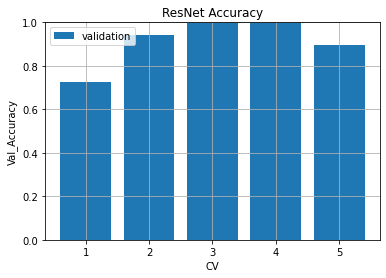

In [17]:
fig1 = plt.gcf()
plt.bar([1,2,3,4,5],VALIDATION_ACCURACY)
# plt.plot(training_accuracy)
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('ResNet Accuracy')
plt.ylabel('Val_Accuracy')
plt.xlabel('CV')
plt.legend(['validation'])
plt.show()

In [7]:
#load the test model
save_dir = root+'/cv_model'
test_model = keras.models.load_model(save_dir+'/model_'+str(3)+'.h5')

2022-12-14 00:39:33.754715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# load test data
test_ds=tf.keras.preprocessing.image_dataset_from_directory(
  root+'/cate_3/test',
  image_size=(256, 256),
  # batch_size=16,
  shuffle=False)

Found 2059 files belonging to 3 classes.


In [15]:
#predict the test data
df_p=pd.DataFrame(test_model.predict(test_ds))
df_p

65/65 [==============================] - 181s 3s/step


,0,1,2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
2054,1.0,0.0,0.0
2055,1.0,0.0,0.0
2056,1.0,0.0,0.0
2057,1.0,0.0,0.0
